<a href="https://colab.research.google.com/github/frrabelo/neural-instrument-cloning/blob/main/Neural_Instrument_Cloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural instrument cloning from few samples:

In this notebook you can :
- Upload your own instrument recording and train an neural instrument clone.
- Use this instrument clone to synthesize an excerpt from a different recording.

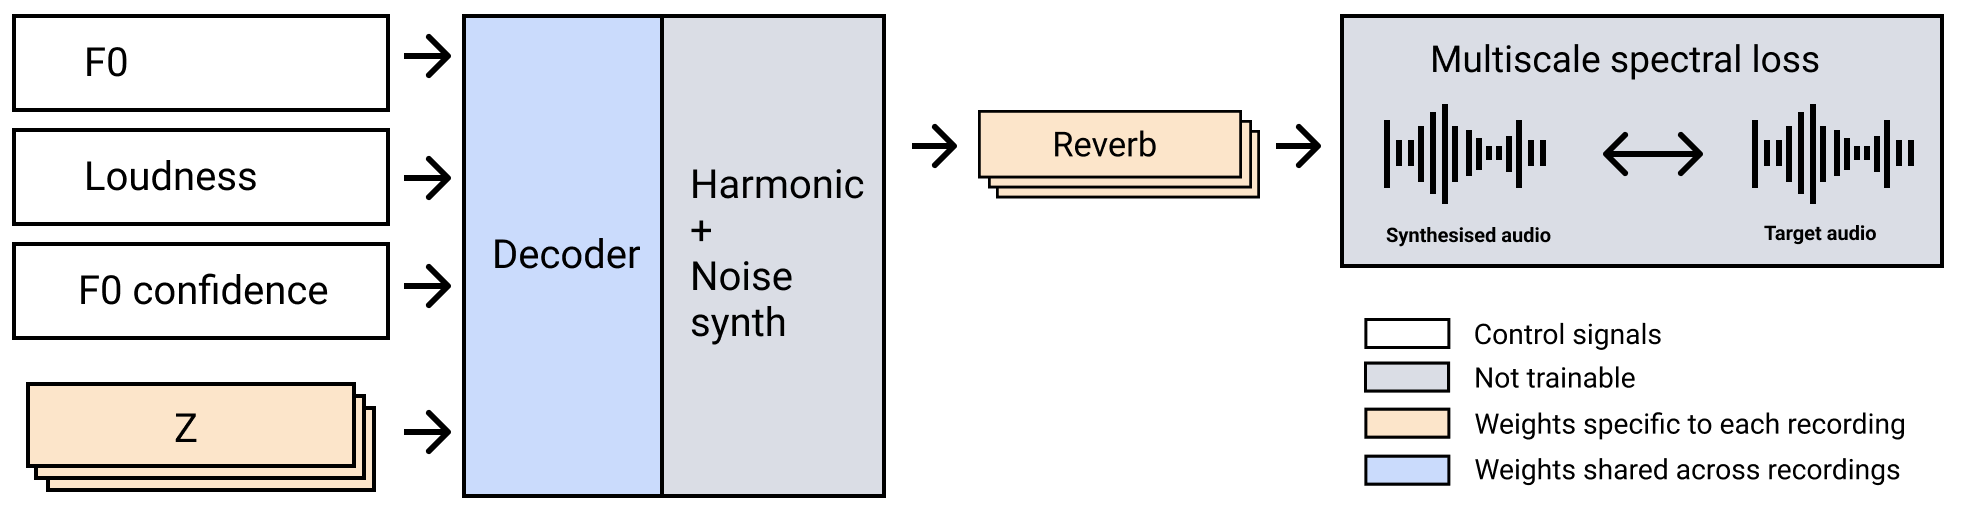

In [ ]:
#@title Select instrument model

#@markdown Currently we offer 4 different models, each trained on a different dataset.
#@markdown ⚠️ Observe that the demo target used for trombone is very sparse.

pretrained_on = "Trombones" #@param ["Saxophones", "Flutes","Trombones","Many different wind instruments (experimental)"]

key2family={
    "Saxophones":"Saxophone",
    "Flutes":"Flute",
    "Trombones":"Trombone",
    "Many different wind instruments (experimental)":"**",
}

INSTRUMENT_FAMILY=key2family[pretrained_on]

# Setup

## Install dependencies

In [ ]:
! git clone https://github.com/erl-j/neural-instrument-cloning.git

In [ ]:
!pip install ddsp==1.6.5
!pip install pydash

In [ ]:
%cd neural-instrument-cloning

In [ ]:
# download sax audio for later experiments
if INSTRUMENT_FAMILY=="Trombone":
  !wget -O test.mp3 https://s9.imslp.org/files/imglnks/usimg/d/d3/IMSLP276021-PMLP448145-Malancioiu_35_Yirdaki.mp3 
elif INSTRUMENT_FAMILY=="Flute":
  !wget -O test.mp3 https://s9.imslp.org/files/imglnks/usimg/d/d3/IMSLP172362-PMLP102945-S._Karg_Elert_Appassionata.mp3
else:
  !wget -O test.mp3 https://s9.imslp.org/files/imglnks/usimg/1/1f/IMSLP397501-PMLP639468-oliveira_melyriques_nicola_mogavero_sax.mp3

## Define models & stuff

In [ ]:
# imports and utils

import tensorflow.compat.v2 as tf
import ddsp.training
_AUTOTUNE = tf.data.experimental.AUTOTUNE
from IPython.display import Audio, display
import numpy as np
import random 
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import time
import data
import random
import copy
import pydash
import tqdm
import soundfile
import os
from typing import Dict, Text
import librosa
from ddsp.colab.colab_utils import record 
import ipywidgets
from IPython.display import clear_output

# define constants
CLIP_S=4
SAMPLE_RATE=48000
N_SAMPLES=SAMPLE_RATE*CLIP_S

SEED=1
FT_FRAME_RATE=250

tf.random.set_seed(
    SEED
)
np.random.seed(SEED)
random.seed(SEED)

# define some utilis
def play(audio,autoplay=False):
  display(Audio(audio,rate=SAMPLE_RATE,autoplay=autoplay))

In [ ]:
class CustomRnnFcDecoder(ddsp.training.nn.OutputSplitsLayer):
  """RNN and FC stacks for f0 and loudness.
  Allows for bidirectionality
  """

  def __init__(self,
               rnn_channels=512,
               rnn_type='gru',
               ch=512,
               layers_per_stack=3,
               input_keys=('ld_scaled', 'f0_scaled','z'),
               output_splits=(('amps', 1), ('harmonic_distribution', 40)),
               bidir=True,
               **kwargs):
    super().__init__(
        input_keys=input_keys, output_splits=output_splits, **kwargs)
    stack = lambda: ddsp.training.nn.FcStack(ch, layers_per_stack)
    
    # z should be considered as input
    self.input_stacks = [stack() for k in self.input_keys]
    
    self.rnn = ddsp.training.nn.Rnn(rnn_channels, rnn_type,bidir=bidir)
    self.out_stack = stack()

  def compute_output(self, *inputs):
    # Initial processing.

    inputs = [stack(x) for stack, x in zip(self.input_stacks, inputs)]

    # Run an RNN over the latents.
    x = tf.concat(inputs, axis=-1)
    x = self.rnn(x)


    x = tf.concat(inputs + [x], axis=-1)

    # Final processing.
    return self.out_stack(x)
 
class MultiInstrumentAutoencoder(ddsp.training.models.autoencoder.Autoencoder):
    def __init__(self,
               preprocessor=None,
               encoder=None,
               decoder=None,
               processor_group=None,
               losses=None,
               n_instruments=None,
               instrument_weight_metadata={},
               **kwargs):
        super().__init__(preprocessor,encoder,decoder,processor_group,losses,**kwargs)
        
        
        self.n_instruments=n_instruments
        self.instrument_weight_metadata=instrument_weight_metadata
        self.initialize_instrument_weights()
    
    def initialize_instrument_weights(self):
        self.instrument_weights={}
        for weight_name,weight_metadata in self.instrument_weight_metadata.items():
            self.instrument_weights[weight_name]=tf.Variable(weight_metadata["initializer"](self.n_instruments))
          
    def call(self, batch, train_shared):
        self.set_is_shared_trainable(train_shared)
        for weight_name,weights in self.instrument_weights.items():
            batch[weight_name]=tf.gather(weights,batch["instrument_idx"])
            if "processing" in self.instrument_weight_metadata[weight_name]:
                batch[weight_name]=self.instrument_weight_metadata[weight_name]["processing"](batch[weight_name])
        
        # this should go in a preprocessor but I'm too lazy to write a custom preprocessor
        batch["f0_confidence"]=batch["f0_confidence"][...,None]
        
        return super().call(batch,training=False)
    
    def set_is_shared_trainable(self,train_shared):
        if self.encoder is not None:
            self.encoder.trainable=train_shared
        if self.decoder is not None:
            self.decoder.trainable=train_shared
        return

class Gain(ddsp.processors.Processor):
    def __init__(self, name: Text = 'gain'):
        super().__init__(name=name)
    
    def get_signal(self, signal: tf.Tensor,
                 gain_scaled: tf.Tensor) -> tf.Tensor:
        return gain_scaled * signal
    
    def get_controls(self,signal: tf.Tensor,
                 gain: tf.Tensor) -> tf.Tensor:
        return {"signal":signal,"gain_scaled":tf.nn.relu(gain)}

In [ ]:
USE_F0_CONFIDENCE=True

# some checkpoints have 1050 instead..
# some have 200

N_INSTRUMENTS=200

N_NOISE_MAGNITUDES=192
N_HARMONICS=192

BIDIRECTIONAL=True

# 512 for single insturment, 1024 for multi
Z_SIZE=1024 if INSTRUMENT_FAMILY=="**" else 512

IR_DURATION=1
IR_SIZE=int(SAMPLE_RATE*IR_DURATION)

preprocessor=ddsp.training.preprocessing.F0LoudnessPreprocessor()

decoder = CustomRnnFcDecoder(
               rnn_channels=512,
               rnn_type='gru',
               ch=512,
               layers_per_stack=3,
               input_keys=("ld_scaled", 'f0_scaled','z',) if not USE_F0_CONFIDENCE else ("ld_scaled", 'f0_scaled','f0_confidence','z'),
               output_splits=(('amps', 1), ('harmonic_distribution', N_HARMONICS),('magnitudes', N_NOISE_MAGNITUDES)),
               bidir=BIDIRECTIONAL
               )

harmonic = ddsp.synths.Harmonic(
    n_samples=N_SAMPLES, sample_rate=SAMPLE_RATE, name='harmonic')

fn = ddsp.synths.FilteredNoise(
    n_samples=N_SAMPLES, window_size=0, initial_bias=-5.0, name='fn')

reverb = ddsp.effects.Reverb(name="reverb",reverb_length=IR_SIZE,add_dry=False, trainable=False)

harmonic_plus_fn= ddsp.processors.Add(name='harmonic+fn')
wet_gain_plus_dry_gain = ddsp.processors.Add(name='wet_gain+dry_gain')

dry_gain = Gain(name='dry_gain')
wet_gain = Gain(name='wet_gain')

dag = [
  (harmonic, ['amps', 'harmonic_distribution', 'f0_hz']),
  (fn, ['magnitudes']),
  (harmonic_plus_fn, ['harmonic/signal', 'fn/signal']),
  (reverb, ["harmonic+fn/signal","ir"]),
  (wet_gain,["reverb/signal","wet_gain"]),
  (dry_gain,["harmonic+fn/signal","dry_gain"]),
  (wet_gain_plus_dry_gain,["wet_gain/signal","dry_gain/signal"])
]

processor_group=ddsp.processors.ProcessorGroup(dag=dag)

fft_sizes = [64]
while fft_sizes[-1]<SAMPLE_RATE//4:
    fft_sizes.append(fft_sizes[-1]*2)
    
print(fft_sizes)

spectral_loss = ddsp.losses.SpectralLoss(loss_type='L1',
                                             fft_sizes=fft_sizes,
                                              mag_weight=1.0,
                                              logmag_weight=1.0)

instrument_weight_metadata = {
    "z":
        {
        "initializer":lambda batch_size: tf.random.normal([batch_size,1,Z_SIZE]),
        "processing":lambda batched_feature: tf.tanh(tf.tile(batched_feature,[1,FT_FRAME_RATE*CLIP_S,1]))
        },
        "ir":
        {
            "initializer":lambda batch_size: tf.zeros([batch_size,IR_SIZE]),
            "processing":lambda batched_feature: tf.tanh(batched_feature)
            
        }
        ,
        "dry_gain":
            {
            "initializer":lambda batch_size : tf.math.sigmoid(tf.ones([batch_size,1])),
             "processing":lambda batched_feature: tf.nn.relu(batched_feature)
            },
      
        "wet_gain":
            {
            "initializer":lambda batch_size :  tf.math.sigmoid(tf.ones([batch_size,1])),
            "processing":lambda batched_feature: tf.nn.relu(batched_feature)
            }
}



In [ ]:
model = MultiInstrumentAutoencoder(
    preprocessor=preprocessor,
    decoder=decoder,
    processor_group=processor_group,
    n_instruments=N_INSTRUMENTS,
    instrument_weight_metadata=instrument_weight_metadata
)

checkpoint_path=f"checkpoints/48k_{'bidir' if BIDIRECTIONAL else 'unidir'}_z{Z_SIZE}_conv_family_{INSTRUMENT_FAMILY}{'_f0c' if USE_F0_CONFIDENCE else ''}"

print(checkpoint_path)

print("loading checkpoint")
model.load_weights(checkpoint_path)


# Train instrument clone

In [ ]:
#@title Select source audio input

#@markdown Choose a recording of the instrument you want to clone. 
#@markdown The pretrained models we offer were pretrained on amateur recordings done in somewhat poor recording conditions so using that kind of recordings will give the best results.


source_input = "example recording" #@param ["example recording", "file upload"]

filename="test.mp3"

if source_input=="file upload":
  from google.colab import files
  uploaded=files.upload()
  filename=list(uploaded.keys())[0]

#@title Load source audio
# window sample with overlap
def window(a, w , o ):
  if o==w:
    return tf.reshape(a,[-1,w])
  else:
    sh = (a.size - w + 1, w)
    st = a.strides * 2
    view = np.lib.stride_tricks.as_strided(a, strides = st, shape = sh)[0::o]
    return view.copy()

def audio2dataset(y,window_s=4,hop_len=3):
  y= y/np.max(np.abs(y)+1e-10)
  y=y[:SAMPLE_RATE*window_s*(y.shape[-1]//(window_s*SAMPLE_RATE))]

  yw=window(y,window_s*SAMPLE_RATE,hop_len*SAMPLE_RATE)

  # compute features
  ld_db=ddsp.spectral_ops.compute_loudness(y,sample_rate=SAMPLE_RATE)
  f0_hz,f0_confidence = ddsp.spectral_ops.compute_f0(y,sample_rate=SAMPLE_RATE,frame_rate=FT_FRAME_RATE)

  ld_dbw=window(ld_db,window_s*FT_FRAME_RATE,hop_len*FT_FRAME_RATE)
  f0_hzw=window(f0_hz,window_s*FT_FRAME_RATE,hop_len*FT_FRAME_RATE)
  f0_confidencew=window(f0_confidence,window_s*FT_FRAME_RATE,hop_len*FT_FRAME_RATE)

  fit_data={"loudness_db":ld_dbw,"audio":yw, "f0_hz":f0_hzw,"f0_confidence":f0_confidencew,"instrument_idx":tf.zeros((yw.shape[0]),dtype=tf.int32),"instrument":tf.zeros((yw.shape[0]),dtype=tf.int32)}
  fit_data=tf.data.Dataset.from_tensor_slices(fit_data)
  return fit_data


seconds_of_training_data = 16 #@param {type:"slider", min:4, max:64, step:4}

# load source file
y,sr = librosa.load(filename,sr=SAMPLE_RATE,duration=seconds_of_training_data)
cloning_data=audio2dataset(y,CLIP_S,1)

print("training data:")
play(y)

#MAX_DURATION=64
#if y.shape[-1]>SAMPLE_RATE*MAX_DURATION:
#    y=y[:MAX_DURATION*SAMPLE_RATE]

In [ ]:
#@title Finetune model on source
#@markdown This step can take some time.

finetuning_scheme = "finetune recording specific parts only (recommended)" #@param ["finetune recording specific parts only (recommended)","finetune whole model"]
TRAIN_SHARED=finetuning_scheme == "finetune whole model"

BATCH_SIZE=2

fit_batched=cloning_data.shuffle(1000).batch(BATCH_SIZE)

USE_FNR=True

EARLY_REFLECTION_DURATION=0.2

N_FIT_ITERATIONS=30 if TRAIN_SHARED else int(50*(16/seconds_of_training_data))

VAL_LR=3e-5 if TRAIN_SHARED else 3e-3

DEMO_IR_DURATION=1.0
DEMO_IR_SAMPLES=int(DEMO_IR_DURATION*SAMPLE_RATE)


# load model
model = MultiInstrumentAutoencoder(
preprocessor=preprocessor,
decoder=decoder,
processor_group=processor_group,
n_instruments=N_INSTRUMENTS,
instrument_weight_metadata=instrument_weight_metadata
)

# load model weights       

model.set_is_shared_trainable(True)
model.load_weights(checkpoint_path)

model.instrument_weight_metadata["ir"]["initializer"]=lambda batch_size: tf.zeros([batch_size,int(DEMO_IR_DURATION*SAMPLE_RATE)])


if USE_FNR:

    er_samples=int(EARLY_REFLECTION_DURATION*SAMPLE_RATE)

    er_amp=np.ones((er_samples))
    er_amp[er_samples//2:er_samples]=np.linspace(1,0,er_samples//2)

    frame_rate=1000
    n_filter_bands=100
    n_frames=int(frame_rate*DEMO_IR_DURATION)

    ir_fn=ddsp.synths.FilteredNoise(n_samples=DEMO_IR_SAMPLES,
                                        window_size=750,
                                        scale_fn=tf.nn.relu,
                                        initial_bias=0.0001)

    def processing_fn(batched_feature):

        batch_size=batched_feature.shape[0]
        er_ir = tf.nn.tanh(batched_feature[:,:er_samples])

        er_amp=np.ones(DEMO_IR_SAMPLES)
        er_amp[er_samples//2:er_samples]=np.linspace(1,0,er_samples//2)
        er_amp[er_samples:]=0

        er_amp = er_amp[None,:]
        fn_amp= 1-er_amp

        fn_mags=tf.reshape(batched_feature[:,er_samples:],[batch_size,n_frames,n_filter_bands])
        fn_ir=ir_fn(fn_mags)

        ir=fn_ir*fn_amp+tf.pad(er_ir,[[0,0],[0,int(DEMO_IR_DURATION*SAMPLE_RATE)-er_samples]])*er_amp

        #ir = ddsp.core.fft_convolve( fn_ir,er_ir, padding='same', delay_compensation=0)
        return ir

    model.instrument_weight_metadata["ir"]["processing"]=processing_fn

    model.instrument_weight_metadata["ir"]["initializer"]=lambda batch_size: tf.zeros([batch_size,er_samples+n_frames*n_filter_bands])

    model.instrument_weight_metadata["wet_gain"]["initializer"]=lambda batch_size: tf.ones([batch_size,1])*0.1

model.initialize_instrument_weights()
model.set_is_shared_trainable(True)

TMP_CHECKPOINT_PATH="artefacts/tmp_checkpoint"
model.save_weights(TMP_CHECKPOINT_PATH)

model.set_is_shared_trainable(True)
model.load_weights(TMP_CHECKPOINT_PATH)
model.initialize_instrument_weights()

fit_losses=[]

# set up optimizer
val_optimizer = tf.keras.optimizers.Adam(learning_rate=VAL_LR)

for i in tqdm.tqdm(range(N_FIT_ITERATIONS)):
    epoch_loss=0
    batch_counter=0

    for fit_batch in fit_batched:
        with tf.GradientTape() as tape:
          output=model(fit_batch,train_shared=TRAIN_SHARED)
          loss_value=spectral_loss(fit_batch["audio"],output["audio_synth"])
          epoch_loss+=loss_value.numpy()
          batch_counter+=1
          gradients = tape.gradient(loss_value, model.trainable_weights)
        val_optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    fit_losses.append(epoch_loss/batch_counter)

    if False and i%1000==0:
      play(tf.reshape(output["audio_synth"],(-1)))
      plt.plot(fit_losses,label="trn")
      plt.legend()
      plt.show()

      plt.plot(output["ir"][0])
      plt.show()
      pass

# loss plot
plt.plot(fit_losses,label="trn")
plt.legend()
plt.show()

In [ ]:
#@title Use clone to edit training excerpt

print("training excerpt - original")        
play(tf.reshape(fit_batch["audio"],(-1)))

print("training excerpt - resynthesized")     
play(tf.reshape(output['audio_synth'],(-1)))

print("training excerpt - resynthesized transposed down")
transposed_fit_batch = copy.deepcopy(fit_batch)
transposed_fit_batch["f0_hz"]=transposed_fit_batch["f0_hz"]*0.7
transposed_output=model(transposed_fit_batch,train_shared=False)
play(tf.reshape(transposed_output['audio_synth'],(-1)))

print("training excerpt - resynthesized transposed up") 
transposed_fit_batch = copy.deepcopy(fit_batch)
transposed_fit_batch["f0_hz"]=transposed_fit_batch["f0_hz"]*1.3
transposed_output=model(transposed_fit_batch,train_shared=False)
play(tf.reshape(transposed_output['audio_synth'],(-1)))

print("training excerpt - resynthesized w/ much lower loudness") 
transposed_fit_batch = copy.deepcopy(fit_batch)
transposed_fit_batch["loudness_db"]=transposed_fit_batch["loudness_db"]-12
transposed_output=model(transposed_fit_batch,train_shared=False)
play(tf.reshape(transposed_output['audio_synth'],(-1)))

print("training excerpt - resynthesized w/ lower loudness") 
transposed_fit_batch = copy.deepcopy(fit_batch)
transposed_fit_batch["loudness_db"]=transposed_fit_batch["loudness_db"]-6
transposed_output=model(transposed_fit_batch,train_shared=False)
play(tf.reshape(transposed_output['audio_synth'],(-1)))
    
print("training excerpt - resynthesized w/ higher loudness") 
transposed_fit_batch = copy.deepcopy(fit_batch)
transposed_fit_batch["loudness_db"]=transposed_fit_batch["loudness_db"]+6
transposed_output=model(transposed_fit_batch,train_shared=False)
play(tf.reshape(transposed_output['audio_synth'],(-1)))
    
print("training excerpt - resynthesized w/ much higher loudness") 
transposed_fit_batch = copy.deepcopy(fit_batch)
transposed_fit_batch["loudness_db"]=transposed_fit_batch["loudness_db"]+12
transposed_output=model(transposed_fit_batch,train_shared=False)
play(tf.reshape(transposed_output['audio_synth'],(-1)))

print("training excerpt - resynthesized w/ low pitch confidence") 
transposed_fit_batch = copy.deepcopy(fit_batch)
transposed_fit_batch["f0_confidence"]=transposed_fit_batch["f0_confidence"]*0.0
transposed_output=model(transposed_fit_batch,train_shared=False)
play(tf.reshape(transposed_output['audio_synth'],(-1)))

# Use instrument clone

Now that we have trained an insturment clone we are ready to use it to synthesize new audio.

In the following section you can choose from where you want to source the control signals (f0,f0_confidence and loudness).

In [ ]:
#@title Select control audio input
control_input = "example recording" #@param ["example recording", "file upload", "mic input"]
how_much_input = 4 #@param {type:"slider", min:4, max:16, step:4}


def on_record(b):
  clear_output()
  audio=record(seconds=how_much_input+1,sample_rate=SAMPLE_RATE,normalize_db=None)
  global y
  y=audio

if control_input =="mic input":
  button = ipywidgets.Button(description="RECORD")
  button.on_click(on_record)
  display(button)
else:   
  if control_input=="file upload":
    from google.colab import files
    uploaded=files.upload()
    filename=list(uploaded.keys())[0]
  elif control_input == "example recording":
    filename="test.mp3"

  y,sr=librosa.load(filename,sr=SAMPLE_RATE,duration=how_much_input)

  



In [ ]:
#@title Normalize and play control audio input

y=y[:SAMPLE_RATE*how_much_input]

y=y/np.max(np.abs(y)+1e-10)

play(y)
  
edit_data=audio2dataset(y,how_much_input,how_much_input)

In [ ]:
#@title <font>Edit conditioning</font> {vertical-output: true, run: "auto"}

import ipywidgets as widgets
from ipywidgets import Layout, Button, Box
from IPython.display import display, HTML, Image, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from string import Template
from google.colab import output

# load data file

batch=copy.deepcopy(next(iter(edit_data)))

w=1024
square_size=256
MIN_HZ=40
MAX_HZ=1600

template = Template('''

<style>
  .colors-buttons div {
      width: 30px;
      height: 30px;
      margin: 2px;}
  div {
      display: flex;
  }
  canvas{border:1px solid black !important;}
</style>

<div style="display: flex; flex-direction: column;">

<div class="ftButtons" style="display: flex; flex-direction:row; height:50px; justify-content: flex-end; align-items:center;">
  <b style="width: 120px;">Feature:</b>
  <button class="ft" style="color: blue; width:100px;" ft="loudness_scaled">Loudness</button>
  <button class="ft" style="color: red; width:100px;" ft="f0_scaled">Pitch</button>
  <button class="ft" style="color: green; width:100px;" ft="f0_confidence">Pitchyness</button>
</div>

<canvas id="myCanvas" width=$width height=$height></canvas>

</div>

<script>
  var canvas = document.querySelector('canvas')
  var ctx = canvas.getContext('2d')
  var defaultData=$default_data;
  var currentData=JSON.parse(JSON.stringify(defaultData));
  var selectedFt = Object.keys(currentData)[0];
  var ftColours={}

  const ftButtons = document.getElementsByClassName('ft');

  ctx.fillStyle = 'white';
  ctx.fillRect( 0, 0, canvas.width, canvas.height)

  var button = document.querySelector('button')
  var mouse = {x: 0, y: 0}
  var lastPoint={"x":null,"y":null}

  ctx.lineWidth=3;

  canvas.addEventListener('mousemove', function(e) {
    mouse.x = e.pageX - this.offsetLeft
    mouse.y = e.pageY - this.offsetTop
  })

  canvas.onmousedown = ()=>{
    ctx.beginPath()
    ctx.moveTo(mouse.x, mouse.y)
    
    canvas.addEventListener('mousemove', onPaint)
  }
  canvas.onmouseup = ()=>{
    lastPoint={"x":null,"y":null}
    canvas.removeEventListener('mousemove', onPaint)
  }
  canvas.addEventListener ("mouseout", canvas.onmouseup);

  var onPaint = ()=>{

    var mx=mouse.x
    var my=mouse.y

    if(lastPoint.x){
      if(mx<=lastPoint.x){
        ax=mx
        ay=my
        bx=lastPoint.x
        by=lastPoint.y
      }
      else{
        ax=lastPoint.x
        ay=lastPoint.y
        bx=mx
        by=my
      }

      let startIdx = Math.floor(currentData[selectedFt].length*ax/canvas.width)
      let endIdx =Math.floor(currentData[selectedFt].length*bx/canvas.width)
      for(var i=startIdx;i<=endIdx;i++){
        y=ay+(by-ay)*(i-startIdx)/(1+endIdx-startIdx)
        currentData[selectedFt][i]=y/canvas.height;
      }
    }

    lastPoint={"x":mx,"y":my}

    render()
  }

  var render = () =>{

    ctx.clearRect( 0, 0, canvas.width, canvas.height)

    console.log(ftColours["f0"]);

    Object.keys(currentData).forEach(key=>{
      if(key!=selectedFt){

        ctx.strokeStyle = ftColours[key];

        ctx.globalAlpha=0.1;

        ctx.beginPath();
        ctx.moveTo(0,currentData[key][0]*canvas.height);
        
        for(let i=1;i<currentData[key].length;i++){
          ctx.lineTo(i*canvas.width/currentData[key].length, currentData[key][i]*canvas.height);
        }
        ctx.stroke();

      }
      }
    )
  
    ctx.globalAlpha=0.8;

    //draw default

    ctx.setLineDash([4,4]);
    ctx.strokeStyle = 'grey';

    ctx.beginPath();
    ctx.moveTo(0, defaultData[selectedFt][0]*canvas.height);
    
    for(let i=1;i<defaultData[selectedFt].length;i++){
      ctx.lineTo(i*canvas.width/defaultData[selectedFt].length, defaultData[selectedFt][i]*canvas.height);
    }
    ctx.stroke();

    //draw current data

    ctx.setLineDash([]);

    ctx.strokeStyle = ftColours[selectedFt];

    ctx.beginPath();
    ctx.moveTo(0,currentData[selectedFt][0]*canvas.height);
    
    for(let i=1;i<currentData[selectedFt].length;i++){
      ctx.lineTo(i*canvas.width/currentData[selectedFt].length, currentData[selectedFt][i]*canvas.height);
    }
    ctx.stroke();
  }

  Array.from(ftButtons).forEach(ft => {
    console.log(ft)
    ftColours[ft.getAttribute("ft")]=ft.style.color
    ft.addEventListener('click', (event) => {
        selectedFt = event.target.getAttribute('ft');
        render();
    });
  });

  render()
  
    // FINISH BUTTON
  var data = new Promise(resolve=>{
    button.onclick = ()=>{
      resolve(currentData)
    }
  })
</script>
''')

## Show Save Button & Save outputs
button = widgets.Button(description="Render audio")

def db2unit(db):
  return (db / ddsp.spectral_ops.LD_RANGE) + 1.0

def unit2db(ld):
  return (ld - 1.0) * ddsp.spectral_ops.LD_RANGE

def flip(d):
  for key in d.keys():
    d[key]=[1-a for a in d[key]]
  return d
  
## Function to Appear Image Canvas
def tweak_features():

  input = {
          "loudness_scaled":db2unit(batch["loudness_db"]).numpy().tolist(),
          "f0_confidence":batch["f0_confidence"].numpy().tolist(),
          "f0_scaled":ddsp.core.hz_to_unit(batch["f0_hz"],hz_min=MIN_HZ,hz_max=MAX_HZ,clip=True).numpy().tolist()
          }

  input=flip(input)
 
  display(HTML(template.substitute({"width":w, "height":square_size,"default_data":input})))
  if button.on_click(on_button_click):
    pass
  #  pass

def on_button_click(d):
  data = eval_js("data")

  out=flip(data)

  new_batch=copy.deepcopy(batch)

  new_batch["loudness_db"]=unit2db(np.array(out["loudness_scaled"]))
  new_batch["f0_hz"]=ddsp.core.unit_to_hz(np.array(out["f0_scaled"]),hz_min=MIN_HZ,hz_max=MAX_HZ).numpy()
  new_batch["f0_confidence"]=np.array(out["f0_confidence"])
  new_batch["audio"]=new_batch["audio"].numpy()

  new_batch["instrument"]=new_batch["instrument"]
  new_batch["instrument_idx"]=new_batch["instrument_idx"]

  windowed_batch = {}

  RENDER_OVERLAP_S=1
  batch_seconds = new_batch["audio"].shape
  for c in ["f0_hz","f0_confidence","loudness_db"]:
    windowed_batch[c]=window(new_batch[c],4*FT_FRAME_RATE,3*FT_FRAME_RATE)
  windowed_batch["audio"]=window(new_batch["audio"],4*SAMPLE_RATE,3*SAMPLE_RATE)
  windowed_batch["instrument_idx"]=tf.zeros(windowed_batch["audio"].shape[0],dtype=tf.int32)
  windowed_batch["instrument"]=tf.ones(windowed_batch["audio"].shape[0])

  wd_dataset=tf.data.Dataset.from_tensor_slices(windowed_batch)

  audios=[]

  for d in wd_dataset.batch(1):
    out2=model(d,False)
    audios.append(out2["audio_synth"][0])

  out=np.zeros(N_SAMPLES*len(audios))

  out[:N_SAMPLES]=audios[0]

  taper = np.concatenate([np.linspace(0,1,RENDER_OVERLAP_S*SAMPLE_RATE),np.ones(N_SAMPLES-(RENDER_OVERLAP_S*SAMPLE_RATE*2)),np.linspace(1,0,RENDER_OVERLAP_S*SAMPLE_RATE)])

  for ai,a in enumerate(audios[1:]):
    out[(ai+1)*(N_SAMPLES-RENDER_OVERLAP_S*SAMPLE_RATE):(ai+2)*(N_SAMPLES-RENDER_OVERLAP_S*SAMPLE_RATE)+RENDER_OVERLAP_S*SAMPLE_RATE]+=a*taper

  play(out,True)

display(button)

## Show Canvas for the First Time
tweak_features()


